Total High Risk orders: 102955


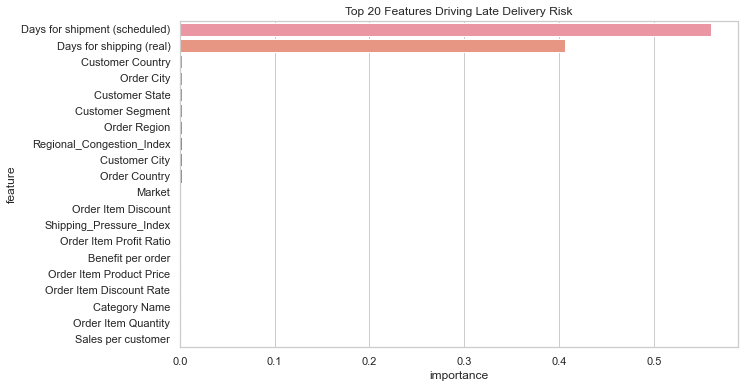

Showing SHAP explanation for Order Index: 0


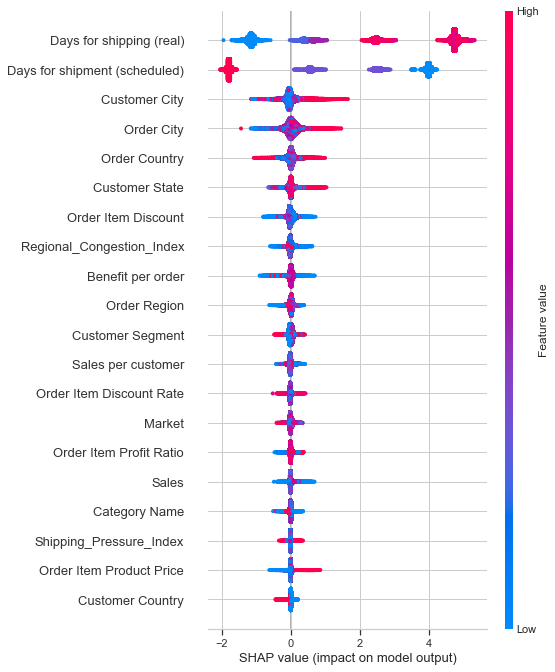

Order-level explanations saved to High_Risk_Order_Explanations.csv


In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

sns.set(style="whitegrid")


# 1️ Load Model, Features & Risk-Scored Data

# 1️ Load Model, Features & Risk-Scored Data

xgb_clf = joblib.load("APL_Logistics_best_model_xgb.pkl")
feature_columns = joblib.load("feature_columns.pkl")

df = pd.read_csv("APL_Logistics_orders_with_risk.csv")
X = df[feature_columns]

# Filter high-risk orders
high_risk = df[df['Risk_Category'] == "High Risk"]

print(f"Total High Risk orders: {high_risk.shape[0]}")
# 2️ Global Feature Importance

importances = xgb_clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title("Top 20 Features Driving Late Delivery Risk")
plt.show()


# 3️ SHAP — Order-Level Explainability
# ===============================
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X)

# Example: explain first high-risk order
order_index = high_risk.index[0]
print(f"Showing SHAP explanation for Order Index: {order_index}")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[order_index], X.iloc[order_index])


# 4️ SHAP Summary for High Risk Orders

shap_values_high_risk = shap_values[high_risk.index]
X_high_risk = X.loc[high_risk.index]

plt.figure(figsize=(12,6))
shap.summary_plot(shap_values_high_risk, X_high_risk, max_display=20)
plt.show()


# 5️ Export Order-Level Explanations
shap_summary = pd.DataFrame(shap_values, columns=feature_columns)
shap_summary['OrderId'] = df.index  # replace with actual order ID if available
shap_summary['Risk_Prob'] = df['Late_Delivery_Prob']
shap_summary['Risk_Category'] = df['Risk_Category']

shap_summary.to_csv("High_Risk_Order_Explanations.csv", index=False)
print("Order-level explanations saved to High_Risk_Order_Explanations.csv")
